Loading the dataset

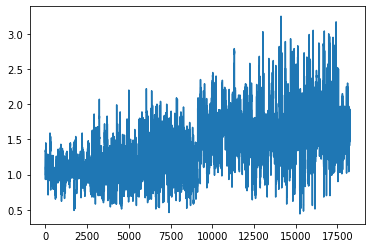

In [11]:
import os
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from tensorflow.python import keras
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
from pandas import read_csv
import pandas as pd
import matplotlib.pyplot as plt

dataset = pd.read_csv('C:\\Users\\Mirela\\PycharmProjects\\Avocado\\avocado.csv',
                      usecols=[2]).values.astype('float64')


from matplotlib import pyplot as plt

avg_price = dataset[:, 0] 

plt.plot(range(len(avg_price)), avg_price)



Plotting the Avg. Price timeseries

In [12]:
# Helper function to get y as a numpy array from the TimeseriesGenerator
def get_y_from_generator(gen):
    '''
    Get all targets y from a TimeseriesGenerator instance.
    '''
    y = None
    for i in range(len(gen)):
        batch_y = gen[i][1]
        if y is None:
            y = batch_y
        else:
            y = np.append(y, batch_y)
    y = y.reshape((-1,1))
    print(y.shape)
    return y

Preparing the data

In [13]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets

train, val, test = dataset[0:12000, :], dataset[12001:13000, :], dataset[13001:None, :]

lookback = 40
step = 1
batch_size = 128

train_data_gen = TimeseriesGenerator(train, train,
                                     length=lookback, sampling_rate=step, stride=1,shuffle=True,
                                     batch_size=batch_size)

val_data_gen = TimeseriesGenerator(val, val,
                                   length=lookback, sampling_rate=step, stride=1,
                                   batch_size=batch_size)

test_data_gen = TimeseriesGenerator(test, test,
                                    length=lookback, sampling_rate=step, stride=1,
                                    batch_size=batch_size)

val_steps = (13000 - 12001 - lookback)
test_steps = (len(dataset) - 13001 - lookback)

Training and evaluating a GRU-based model

Epoch 1/10
500/500 [==============================] - 26s 52ms/step - loss: 0.0691 - val_loss: 0.1130
Epoch 2/10
500/500 [==============================] - 25s 50ms/step - loss: 0.0528 - val_loss: 0.1001
Epoch 3/10
500/500 [==============================] - 25s 50ms/step - loss: 0.0504 - val_loss: 0.0959
Epoch 4/10
500/500 [==============================] - 25s 50ms/step - loss: 0.0492 - val_loss: 0.0635
Epoch 5/10
500/500 [==============================] - 25s 51ms/step - loss: 0.0488 - val_loss: 0.1131
Epoch 6/10
500/500 [==============================] - 25s 51ms/step - loss: 0.0480 - val_loss: 0.0927
Epoch 7/10
500/500 [==============================] - 26s 51ms/step - loss: 0.0485 - val_loss: 0.1074
Epoch 8/10
500/500 [==============================] - 25s 51ms/step - loss: 0.0479 - val_loss: 0.0933
Epoch 9/10
500/500 [==============================] - 25s 51ms/step - loss: 0.0480 - val_loss: 0.1135
Epoch 10/10
500/500 [==============================] - 26s 51ms/step - loss: 0.048

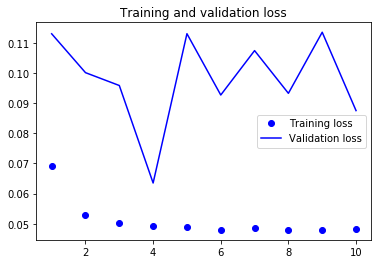

In [17]:
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop
model = Sequential()
model.add(layers.GRU(32, dropout=0.2, recurrent_dropout=0.2,input_shape=(None, dataset.shape[-1])))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_data_gen,steps_per_epoch=500,epochs=10,validation_data=val_data_gen,
validation_steps=val_steps)
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

test loss: 0.06769242882728577
(5208, 1)
Test Score: 0.34 RMSE


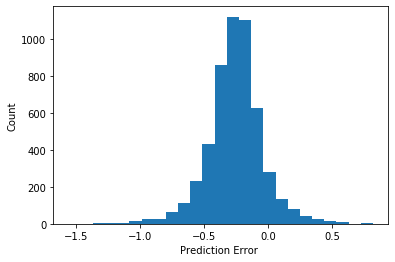

In [18]:
test_loss = model.evaluate_generator(test_data_gen,steps=test_steps)
print('test loss:', test_loss)

testPredict = model.predict_generator(test_data_gen)
testPredict.shape

testPredict = scaler.inverse_transform(testPredict)

testY = get_y_from_generator(test_data_gen)


testY = scaler.inverse_transform(testY)

from sklearn.metrics import mean_squared_error
import math
# calculate root mean squared error
testScore = math.sqrt(mean_squared_error(testY[:, 0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# error distribution
error = testPredict - testY
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error ")
_ = plt.ylabel("Count")



When we have data where temporal ordering matters, recurrent networks are a great fit and easily outperform models that first flatten the temporal data. To use dropout with recurrent networks, you should use a time-constant dropout mask and recurrent dropout mask. These are built into Keras recurrent layers, so all you have to do is use the dropout and recurrent_dropout arguments of recurrent layers. Stacked RNNs provide more representational power than a single RNN layer. They’re also much more expensive and thus not always worth it. Although they offer clear gains on complex problems (such as machine translation), they may not always be relevant to smaller, simpler problems.